<a href="https://colab.research.google.com/github/paras9o9/MachineLearning/blob/main/LifeExpectancyPrediction/notebooks/LEP_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Life Exectancy Prediction (Feature Selection & Preprocessing)

This is Python script desinged for preprocessing and feature selection in a LEP dataset.

# Data Loading
```
df = pd.read_csv("/content/LEP.csv")
```
# Data Cleaning

* Droping non-relevant columns
by specifing labels from rows or columns. Removing rows or columns by specifying label names and corresponding axis, or by directly specifying index or column names.
* Encode categorical feature (Developing = 0, Developed = 1).Status (Developing/Developed) is converted to numeric (0/1).

* Handling missing values (fill with column mean). Missing values are filled with the mean to avoid errors in calculations.We replace NaN values with the mean of each column to maintain data consistency.
* Removing Multicollinear Features using Correlation.
This part of the code helps in removing highly correlated feartures to avoid multicollinearity, which can negativily impact linear regression.
Defines a threshold (0.75) for considering two features as "highly correlated."
If the correlation between two features > 0.75, we consider them too similar and remove one.


# Finding highly correlated features
```
highly_correlated = [column for column in upper_triangle.columns if any(upper_triangle[column] > correlation_threshold)]
```
# Dropping highly correlated features
```
X = X.drop(columns=highly_correlated)
```
# Feature Relevance Using Mutual Information
MI measures the dependency between a featureand the target variable (y = Life Expectancy)
MI is non-linear, meaning it can detect complex relationships between features and the target.
Unlike correlation, MI can detect both linear and non-linear dependencies.
# Selecting Features using Recursive Feature Elimination
RFE is a wrapper method that iterativly removes the least important feature until only the best ones remain.
It helps identify which features contribute the most to predicting Life Expextancy.
# Checking for Multicollinearity using Variance Inflation Factor
"Multicollinearity is bad for linear regression because it makes it hard to determine the true impact of each feature."
VIF measures how much a feature is correlated with other features.
A high VIF (>5 or 10) means the feature is highly correlate with others and should be removed.
# Standardizing Features for Linear Regression
Linear Regression models works better when features have similar scales. Standardization ensures all features are on the same scale by converting them to zero mean and unit variance.











Dropped Highly Correlated Features:
 ['under-five deaths', 'GDP', 'thinness 5-9 years', 'Schooling']


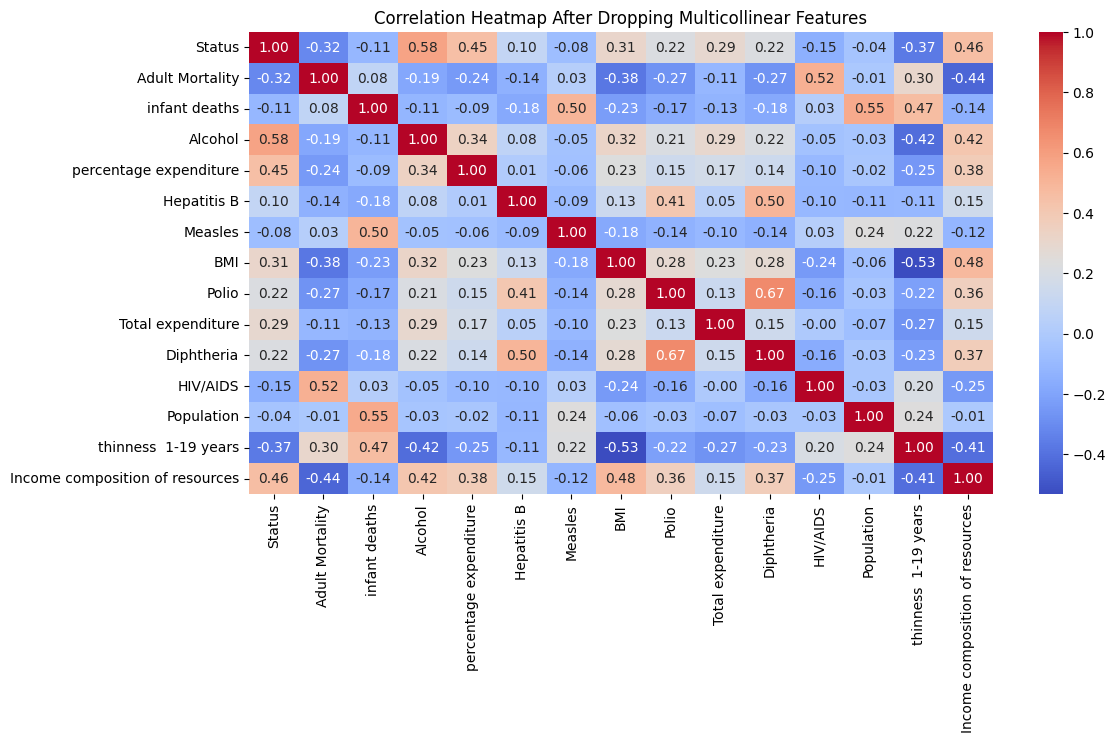


Mutual Information Scores:
 Adult Mortality                    1.276528
Income composition of resources    0.929440
thinness  1-19 years               0.784401
BMI                                0.574324
HIV/AIDS                           0.535493
infant deaths                      0.424907
Alcohol                            0.347267
Polio                              0.318989
Diphtheria                         0.304309
percentage expenditure             0.297917
Total expenditure                  0.255376
Hepatitis B                        0.202078
Status                             0.200402
Population                         0.150078
Measles                            0.117109
dtype: float64

Top 10 Selected Features by RFE:
 Index(['Status', 'Adult Mortality', 'Alcohol', 'BMI', 'Polio',
       'Total expenditure', 'Diphtheria', 'HIV/AIDS', 'thinness  1-19 years',
       'Income composition of resources'],
      dtype='object')

Variance Inflation Factor (VIF) for Selected Features:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_regression, RFE
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Loading Dataset
df = pd.read_csv("/content/LEP.csv")

# Droping non-relevant columns
df = df.drop(columns=["Country", "Year"])

# Encode categorical feature
df["Status"] = df["Status"].map({"Developing": 0, "Developed": 1})

# Handling missing values
df = df.fillna(df.mean())

X = df.drop(columns=["Life expectancy"])
y = df["Life expectancy"]

# Removing Multicollinear Features using Correlation
correlation_threshold = 0.75
corr_matrix = X.corr().abs()

upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
highly_correlated = [column for column in upper_triangle.columns if any(upper_triangle[column] > correlation_threshold)]

X = X.drop(columns=highly_correlated)
print("\nDropped Highly Correlated Features:\n", highly_correlated)

# Plotting Correlation Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(X.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap After Dropping Multicollinear Features")
plt.show()

# Feature Relevance Using Mutual Information
mi_scores = mutual_info_regression(X, y)
mi_scores = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)
print("\nMutual Information Scores:\n", mi_scores)

# Linear Model
model = LinearRegression()

# Selecting Features using Recursive Feature Elimination
rfe = RFE(model, n_features_to_select=10)
rfe.fit(X, y)
selected_features_rfe = X.columns[rfe.support_]
print("\nTop 10 Selected Features by RFE:\n", selected_features_rfe)

# Checking for Multicollinearity using Variance Inflation Factor
X_selected = X[selected_features_rfe]
vif_data = pd.DataFrame()
vif_data["Feature"] = X_selected.columns
vif_data["VIF"] = [variance_inflation_factor(X_selected.values, i) for i in range(X_selected.shape[1])]
print("\nVariance Inflation Factor (VIF) for Selected Features:\n", vif_data)

# Standardizing Features for Linear Regression
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

# Convert the scaled NumPy array back to a pandas DataFrame.
X_final = pd.DataFrame(X_scaled, columns=selected_features_rfe)

print("\nFinal Selected Features Ready for Linear Regression:\n", X_final.head())

# Training and testing the Linear Regression Model

For Training I used:
```
from sklearn.model_selection import train_test_split
```
To split the dataset into 80% training and 20% testing sets.

For Evaluating the model:
```
from sklearn.metrics import mean_squared_error, r2_score
```
I used metrics such as Means Squared Error and R2 Score to evaluate how well the model performs.



In [2]:
# Spliting the data into training and testing sets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

# Training the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Making the prediction
y_pred = model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModel Evaluation:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R² Score): {r2:.2f}")


Model Evaluation:
Mean Squared Error (MSE): 18.81
R-squared (R² Score): 0.78


# Plotting "Feature Importance" of the model

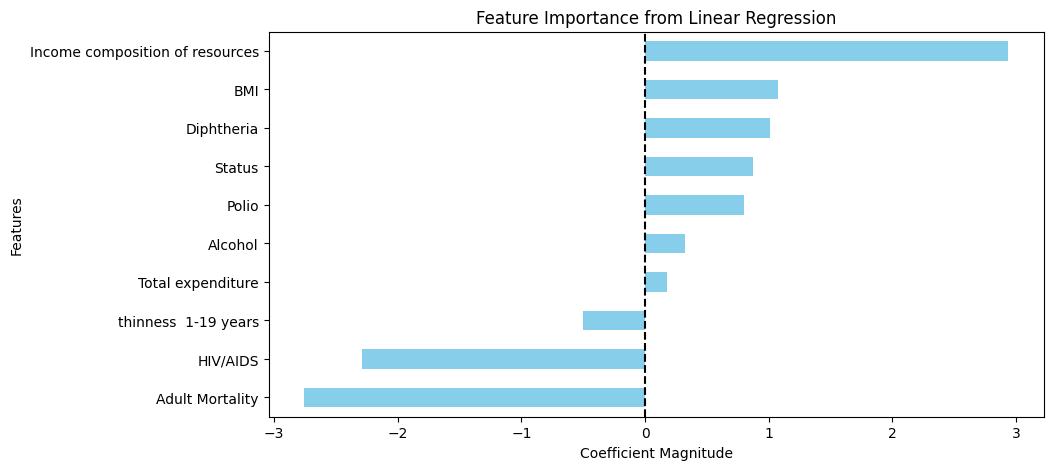

In [4]:
feature_importance = pd.Series(model.coef_, index=X_train.columns).sort_values()

plt.figure(figsize=(10, 5))
feature_importance.plot(kind="barh", color="skyblue")
plt.title("Feature Importance from Linear Regression")
plt.xlabel("Coefficient Magnitude")
plt.ylabel("Features")
plt.axvline(0, color="black", linestyle="--")
plt.show()

# Improving performance by applying Interaction Terms and Polynomial Features Transformation
Interaction terms are new features creared by mulityplying two existing features.
This allow a model like Linear Regression to capture non-linear interactions between varaibles.

# Creating Interaction terms
What features can be combined and why?

*   Combined effect of Body Mass Index (BMI) and Alcohol consumption may influence life expectancy more than either alone.
* People in regions with high adult mortality have higher chances to be more affected than expected from each individually.

*   The higher the income and better education might amplify each other's impact on life expectancy.
*   Vaccincation coverage in both Polio and Diphyeria could have a stronger combined impact on health outcomes.

# Adding new feature to X
This can increase the dimensinality of the feature space but also gives the model more power to capture relationships that linear terms might miss.

# Polynomial features
Applying Polynomial Features (degree = 2) to capture more complex relationships between features.

Applying Featuers Transformation, log and square root transformations to specific features, which is a great technique for handling skewed data and improving model performance.

# Updated Model Evaluation
After adding interaction terms and transformations (log, sqrt, polynomial features), I am retraining the model.
*   Updated MSE: 15.13
*   Updated R² Score: 0.83






In [5]:
# Creating Interaction terms
df["BMI_Alcohol"] = df["BMI"] * df["Alcohol"]
df["Mortality_HIV"] = df["Adult Mortality"] * df["HIV/AIDS"]
df["Income_Schooling"] = df["Income composition of resources"] * df["Schooling"]
df["Polio_Diphtheria"] = df["Polio"] * df["Diphtheria"]

# Adding new feature to X
X["BMI_Alcohol"] = df["BMI_Alcohol"]
X["Mortality_HIV"] = df["Mortality_HIV"]
X["Income_Schooling"] = df["Income_Schooling"]
X["Polio_Diphtheria"] = df["Polio_Diphtheria"]

In [6]:
from sklearn.preprocessing import PolynomialFeatures

# Applying Polynomial Features
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_poly = poly.fit_transform(X)

# Convert back to the DataFrame
X_poly_df = pd.DataFrame(X_poly, columns=poly.get_feature_names_out(X.columns))

In [7]:
X["log_Population"] = np.log1p(X["Population"])
X["sqrt_Expenditure"] = np.sqrt(X["Total expenditure"])

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  random_state=42)

# Retraining the Model
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate MSE and R2 Score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Updated MSE: {mse:.2f}")
print(f"Updated R² Score: {r2:.2f}")

Updated MSE: 15.13
Updated R² Score: 0.83


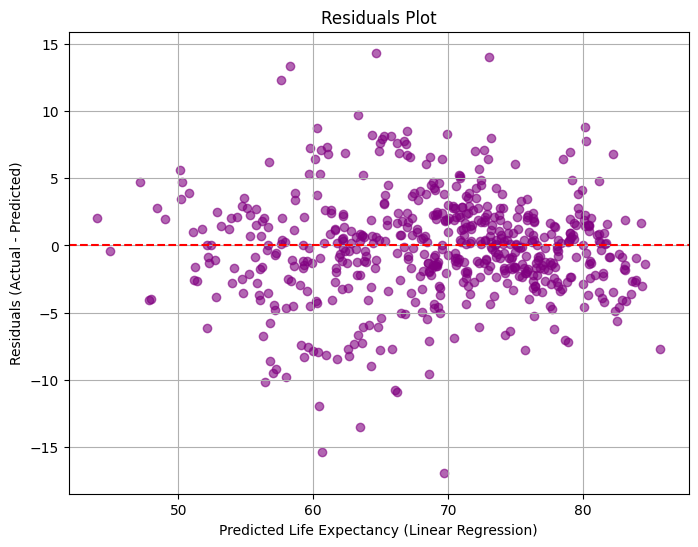

In [9]:
# Residual Plot
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, color='purple', alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted Life Expectancy (Linear Regression)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals Plot")
plt.grid(True)
plt.show()

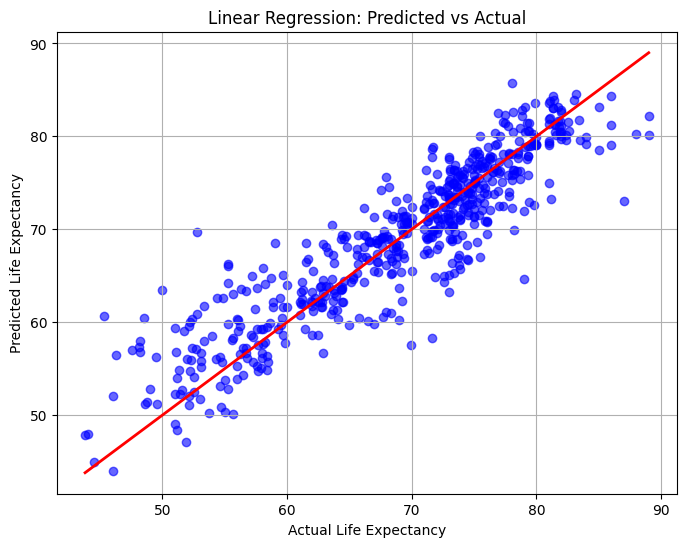

In [10]:
# Plot: Predicted vs Actual Life Execpancy
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
plt.xlabel("Actual Life Expectancy")
plt.ylabel("Predicted Life Expectancy")
plt.title("Linear Regression: Predicted vs Actual")
plt.grid(True)
plt.show()

# Analysis of Feature Importance from Linear Regression
feature importance plot helps interpret how each feature impacts Life Expectancy in the model.

Features with positive values contribute positively to life expectancy.

Features with negative values have a negative impact on life expectancy.

Features with larger bars have more influence on predictions. If some features have very small coeffcients, they might be less relevent consider removing them.
  

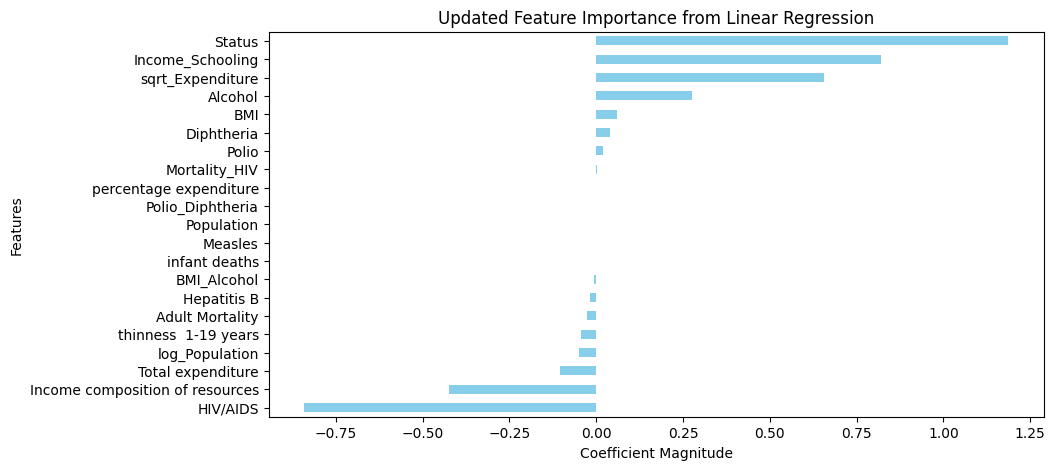

In [11]:
feature_importance = pd.Series(model.coef_, index=X_train.columns).sort_values()

plt.figure(figsize=(10, 5))
feature_importance.plot(kind="barh", color="skyblue")
plt.title("Updated Feature Importance from Linear Regression")
plt.xlabel("Coefficient Magnitude")
plt.ylabel("Features")
plt.show()

# Checking for Multicollinearity

As the VIF indicate severe multicollinearity in some features, which can negatively impact model stability.

When see very high VIFs like this, it's strong sign of multicollinearity.

And to address multicollinearity I have dropped one of each highly correlated pair.


In [12]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a DataFrame to store VIF values
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]

# Display VIF Values
print(vif_data)

                            Feature         VIF
0                            Status    2.503419
1                   Adult Mortality    6.394823
2                     infant deaths    2.127032
3                           Alcohol   16.561318
4            percentage expenditure    1.587847
5                       Hepatitis B   19.539131
6                           Measles    1.401660
7                               BMI   15.473493
8                             Polio   88.181522
9                 Total expenditure  130.082021
10                       Diphtheria   90.109510
11                         HIV/AIDS    4.938600
12                       Population    1.511929
13             thinness  1-19 years    4.336748
14  Income composition of resources   99.187396
15                      BMI_Alcohol   17.893176
16                    Mortality_HIV    5.653830
17                 Income_Schooling   63.745972
18                 Polio_Diphtheria  124.453143
19                   log_Population   33

In [13]:
# VIF Handling
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

X_vif = X.copy()

X_vif.drop(columns=["sqrt_Expenditure", "Population", "Polio", "Diphtheria", "BMI", "Alcohol", "Adult Mortality", "HIV/AIDS", "Income composition of resources"], inplace=True)

X_vif_with_const = pd.DataFrame(StandardScaler().fit_transform(X_vif), columns=X_vif.columns)

vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif_with_const.values, i) for i in range(X_vif_with_const.shape[1])]

print("\n VIF after dropping high-VIF features:")
print(vif_data.sort_values(by="VIF", ascending=False))


 VIF after dropping high-VIF features:
                   Feature       VIF
9         Income_Schooling  2.198581
7              BMI_Alcohol  1.998286
0                   Status  1.907949
6     thinness  1-19 years  1.788904
1            infant deaths  1.726097
10        Polio_Diphtheria  1.689764
3              Hepatitis B  1.388378
2   percentage expenditure  1.381215
4                  Measles  1.346103
5        Total expenditure  1.170876
8            Mortality_HIV  1.060948
11          log_Population  1.046312


# Taking a step further by using Ridge Regression
It is a quick comparision in betweent Linear Regression Model and Ridge Regeression Model

# Standardizing Features
Firstly, I standardized the features as Ridge is very sensitive to scale.

# Ridge Regression
It is a type of linea model that uses something called L2 regularization. That just means it adds the square of the coefficients as a penalty in the cost function.

In Ridge Regression, alpha (also called the regularization strength) controls how much I penalize large coefficients. Just like a knob.

Best alpha: 10 means that the value alpha=10 gave the best performance (lowest MSE) on the validation set during cross-validation.

Ridge MSE: 15.18 means the model’s predictions are on average, around √15.18 ≈ 3.9 years off in terms of life expectancy.

Ridge R2 Score: 0.82 indicates the model explains 82% of the variance in the life expectancy data.


In [14]:
from sklearn.preprocessing import StandardScaler
# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
# Ridge Regression
ridge = Ridge()
params = {'alpha': [0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(ridge, params, scoring='neg_mean_squared_error')
grid.fit(X_train_scaled, y_train)
# Predication
best_ridge = grid.best_estimator_
y_pred_ridge = best_ridge.predict(X_test_scaled)
# Evaluation
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print(f"Best alpha: {grid.best_params_['alpha']}")
print(f"Ridge MSE: {mse_ridge:.2f}")
print(f"Ridge R2 Score: {r2_ridge:.2f}")

Best alpha: 10
Ridge MSE: 15.18
Ridge R2 Score: 0.82


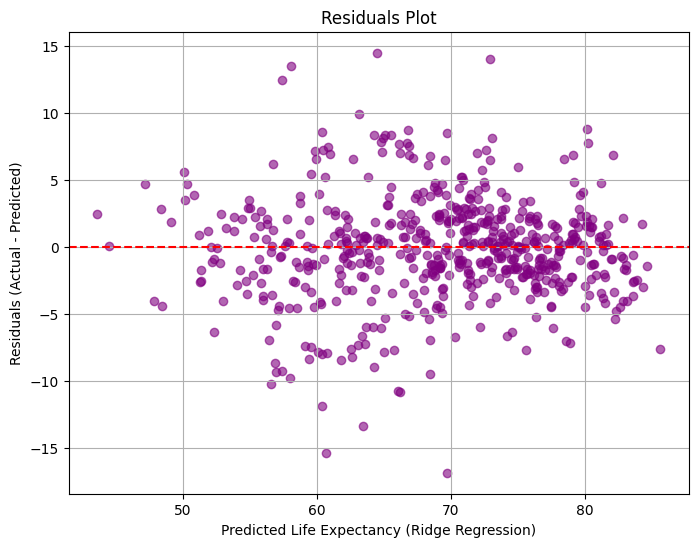

In [16]:
# Residual Plot
residuals = y_test - y_pred_ridge

plt.figure(figsize=(8, 6))
plt.scatter(y_pred_ridge, residuals, color='purple', alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted Life Expectancy (Ridge Regression)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals Plot")
plt.grid(True)
plt.show()

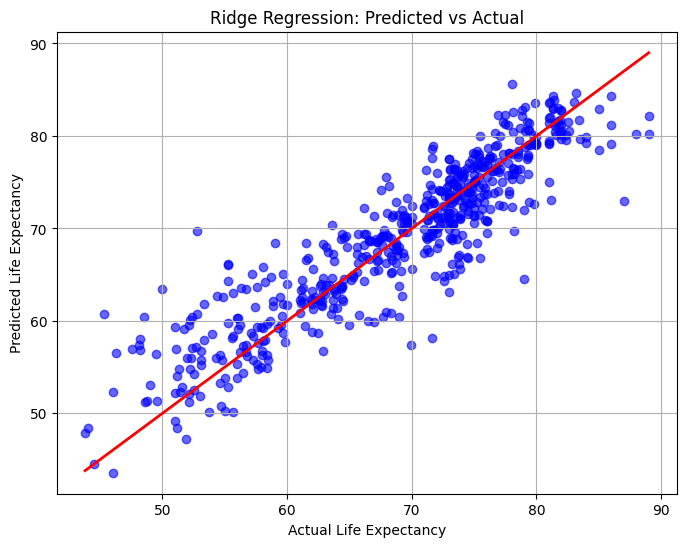

In [17]:
# Plot: Predicted vs Actual Life Execpancy
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_ridge, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
plt.xlabel("Actual Life Expectancy")
plt.ylabel("Predicted Life Expectancy")
plt.title("Ridge Regression: Predicted vs Actual")
plt.grid(True)
plt.show()